In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [2]:
path = './data/2022-06-20T22-00-37/'
test_path = './data/2022-06-20T22-00-18/'

## Interpolate poses and frames for COLMAP model aligner

In [3]:
df = pd.read_csv(path + 'ARposes.txt', sep = ",",header=None)
df.columns = ['time', 'POS_X', 'POS_Y', 'POS_Z', 'Q_W', 'Q_X', 'Q_Y', 'Q_Z']
df.head()
test_df = pd.read_csv(test_path + 'ARposes.txt', sep = ",",header=None)
test_df.columns = ['time', 'POS_X', 'POS_Y', 'POS_Z', 'Q_W', 'Q_X', 'Q_Y', 'Q_Z']

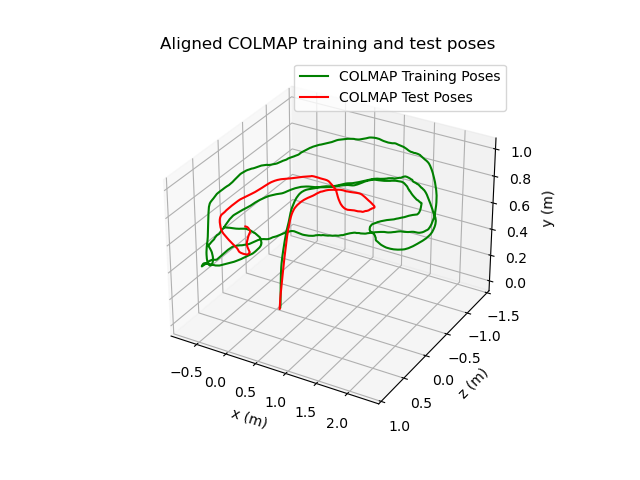

In [10]:
%matplotlib ipympl
plt.figure()
ax = plt.axes(projection= '3d')
start = 0
end = -1
# +ve x is right, +ve y is up, +ve z is south
ax.plot3D(df["POS_X"][start:end], df["POS_Z"][start:end], df["POS_Y"][start:end], label = "ARKIT Train Poses", color = 'green')
ax.plot3D(test_df["POS_X"][start:end], test_df["POS_Z"][start:end], test_df["POS_Y"][start:end], label = "ARKIT Test Poses", color = 'red')
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_ylim([1.0, -1.5])
ax.set_zlabel("y (m)")
ax.set_title("Rough COLMAP Alignment and IMU poses")
ax.legend()
plt.show()

In [ ]:
df = test_df
path = test_path

<AxesSubplot:>

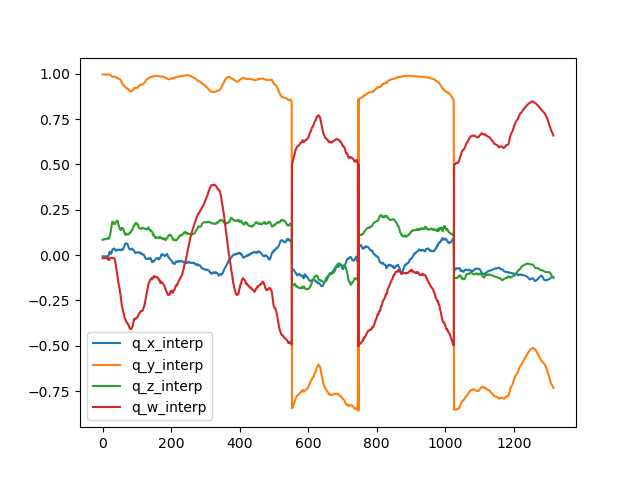

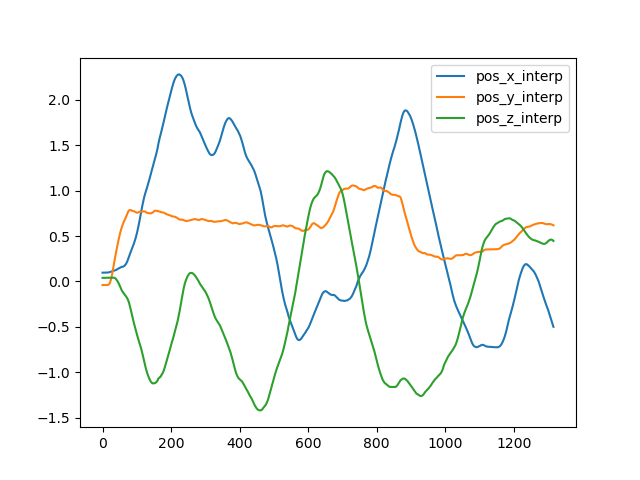

In [11]:
frames_df = pd.read_csv(path + 'Frames.txt', sep = ",",header=None)
frames_df.columns = ['time','frameNumber','focalLenghtX','focalLenghtY','principalPointX','principalPointY']
frames_df["pos_x_interp"] = np.interp(frames_df["time"], df["time"], df["POS_X"])
frames_df["pos_y_interp"] = np.interp(frames_df["time"], df["time"], df["POS_Y"])
frames_df["pos_z_interp"] = np.interp(frames_df["time"], df["time"], df["POS_Z"])
frames_df["q_w_interp"] = np.interp(frames_df["time"], df["time"], df["Q_W"])
frames_df["q_x_interp"] = np.interp(frames_df["time"], df["time"], df["Q_X"])
frames_df["q_y_interp"] = np.interp(frames_df["time"], df["time"], df["Q_Y"])
frames_df["q_z_interp"] = np.interp(frames_df["time"], df["time"], df["Q_Z"])
frames_df[["q_x_interp", "q_y_interp", "q_z_interp",'q_w_interp']].plot()
frames_df[["pos_x_interp", "pos_y_interp", "pos_z_interp"]].plot()

In [12]:
arkit_poses = frames_df[["frameNumber", "pos_x_interp", "pos_y_interp", "pos_z_interp","q_w_interp","q_x_interp","q_y_interp","q_z_interp"]]
arkit_poses.rename(columns={"pos_x_interp": "POS_X", "pos_y_interp":"POS_Y", "pos_z_interp":"POS_Z","q_w_interp":"Q_W","q_x_interp":"Q_X","q_y_interp":"Q_Y","q_z_interp":"Q_Z"}, inplace=True)

C:\Users\tansi\AppData\Local\Temp\ipykernel_18196\3303755249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arkit_poses.rename(columns={"pos_x_interp": "POS_X", "pos_y_interp":"POS_Y", "pos_z_interp":"POS_Z","q_w_interp":"Q_W","q_x_interp":"Q_X","q_y_interp":"Q_Y","q_z_interp":"Q_Z"}, inplace=True)


In [13]:
arkit_poses.to_csv("arkit_poses.csv")

## Get reference points from ARKit for aligning COLMAP

In [ ]:
train = True
if train:
    print(frames_df[frames_df.frameNumber.isin([0, 300, 600])][["pos_x_interp","pos_y_interp", "pos_z_interp"]])
else:
    print(frames_df[frames_df.frameNumber.isin([0, 200, 400])][["pos_x_interp","pos_y_interp", "pos_z_interp"]])

## Align ARKit with DeviceMotion Reference frame

In [ ]:
def quat_to_euler(row):
    r = R.from_quat([row["q_x_interp"], row["q_y_interp"], row["q_z_interp"], row["q_w_interp"]])
    return r.as_euler('YXZ', degrees=True)
euler = frames_df.apply(lambda row : quat_to_euler(row), axis = 1)
df_euler = pd.DataFrame(euler.to_list(), columns=['roll','pitch', 'yaw'])
df_euler.plot()

In [ ]:
orientation = pd.read_csv(path + 'Motion.txt', sep = ",",header=None)
orientation.columns = ['time','imu_Q_W', 'imu_Q_X', 'imu_Q_Y', 'imu_Q_Z']
frames_df["imu_Q_W"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_W"])
frames_df["imu_Q_X"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_X"])
frames_df["imu_Q_Y"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_Y"])
frames_df["imu_Q_Z"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_Z"])
frames_df[['imu_Q_W', 'imu_Q_X', 'imu_Q_Y', 'imu_Q_Z']].plot()

In [ ]:
def quat_to_euler(row):
    r = R.from_quat([row["imu_Q_X"], row["imu_Q_Y"], row["imu_Q_Z"], row["imu_Q_W"]])
    rotate = R.from_euler("Y", 90, degrees=True)
    rotated = (r*rotate).as_euler('xyz', degrees= True)
    return -rotated[0], -rotated[1], rotated[2]
euler = frames_df.apply(lambda row : quat_to_euler(row), axis = 1)
df_euler2 = pd.DataFrame(euler.to_list(), columns=['pitch','roll', 'yaw'])
df_euler2.plot()

In [ ]:
mot_arh = pd.read_csv(path + 'MotARH.txt', sep = ",",header=None)
mot_arh.columns = ['time',
                   'ang_vel_x','ang_vel_y','ang_vel_z',
                   'gravity_x','gravity_y','gravity_z',
                   'imu_acc_x','imu_acc_y','imu_acc_z', 
                   'motionHeading'] # These values are in body frame
mot_arh.head()  

In [ ]:
mot_arh[['imu_acc_x', 'imu_acc_y', 'imu_acc_z']].plot()
mot_arh[['ang_vel_x','ang_vel_y','ang_vel_z']].plot()
mot_arh[["gravity_x", "gravity_y", "gravity_z"]].plot()


In [ ]:
device_motion = pd.concat([mot_arh, orientation[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W']]], axis=1)
device_motion.head()

In [ ]:
def convert_body_to_world(body_acc, world_orientation):
    """Converting linear acceleration in body frame to world frame"""
    r = R.from_quat(world_orientation)
    world_acc = r.apply(body_acc)
    return world_acc
    
global_accel = device_motion.apply(lambda row: convert_body_to_world(
                                                    np.array(row[['imu_acc_x', 'imu_acc_y', 'imu_acc_z']]),
                                                    np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]])), axis=1)
global_accel = pd.DataFrame(global_accel.to_list(), columns=['imu_acc_x_global', 'imu_acc_y_global', 'imu_acc_z_global'])

global_ang = device_motion.apply(lambda row: convert_body_to_world(
                                                    np.array(row[['ang_vel_x', 'ang_vel_y', 'ang_vel_z']]),
                                                    np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]])), axis=1)
global_ang = pd.DataFrame(global_ang.to_list(), columns=['ang_vel_x_global', 'ang_vel_y_global', 'ang_vel_z_global'])

In [ ]:
global_accel[['imu_acc_x_global', 'imu_acc_y_global', 'imu_acc_z_global']].plot()
global_ang[['ang_vel_x_global', 'ang_vel_y_global', 'ang_vel_z_global']].plot()

In [ ]:
new_device_motion = pd.concat([device_motion, global_accel, global_ang], axis=1)
new_device_motion["seconds"] = new_device_motion["time"] - new_device_motion["time"][0]
new_device_motion["timestep"] = new_device_motion["time"] - new_device_motion["time"].shift(1)

In [ ]:
from scipy import integrate
from scipy import signal

plt.figure()
new_device_motion["seconds"] = new_device_motion["time"] - new_device_motion["time"][0]
t = new_device_motion["seconds"]
vel_x = integrate.cumtrapz(new_device_motion["imu_acc_x_global"]*-9.81, t, initial=0)
vel_y = integrate.cumtrapz(new_device_motion["imu_acc_y_global"]*-9.81, t, initial=0)
vel_z = integrate.cumtrapz(new_device_motion["imu_acc_z_global"]*-9.81, t, initial=0) 

plt.plot(vel_x, label = "vel_x")
plt.plot(vel_y, label = "vel_y")
plt.plot(vel_z, label = "vel_z")
plt.legend()
vel_x = signal.detrend(vel_x)
vel_y = signal.detrend(vel_y)
vel_z = signal.detrend(vel_z)

pos_x = integrate.cumtrapz(vel_x, t, initial=0)
pos_y = integrate.cumtrapz(vel_y, t, initial=0)
pos_z = integrate.cumtrapz(vel_z, t, initial=0)
plt.figure() 
plt.plot(t,-pos_y, label = 'pos_x')
plt.plot(t,pos_z, label = 'pos_y')
plt.plot(t,-pos_x, label = 'pos_z')
plt.legend()

In [ ]:
new_device_motion["lin_vel_x"] = integrate.cumtrapz(new_device_motion["imu_acc_x_global"], new_device_motion["time"], initial=0)
new_device_motion["lin_vel_y"] = integrate.cumtrapz(new_device_motion["imu_acc_y_global"], new_device_motion["time"], initial=0)
new_device_motion["lin_vel_z"] = integrate.cumtrapz(new_device_motion["imu_acc_z_global"], new_device_motion["time"], initial=0)
new_device_motion["prev_lin_vel_x"] = new_device_motion["lin_vel_x"].shift(1)
new_device_motion["prev_lin_vel_y"] = new_device_motion["lin_vel_y"].shift(1)
new_device_motion["prev_lin_vel_z"] = new_device_motion["lin_vel_z"].shift(1)
new_device_motion["prev_imu_acc_x"] = new_device_motion["imu_acc_x"].shift(1)
new_device_motion["prev_imu_acc_y"] = new_device_motion["imu_acc_y"].shift(1)
new_device_motion["prev_imu_acc_z"] = new_device_motion["imu_acc_z"].shift(1)
new_device_motion["prev_ang_vel_x_global"] = new_device_motion["ang_vel_x_global"].shift(1)
new_device_motion["prev_ang_vel_y_global"] = new_device_motion["ang_vel_y_global"].shift(1)
new_device_motion["prev_ang_vel_z_global"] = new_device_motion["ang_vel_z_global"].shift(1)

In [ ]:
import rowan

qw = frames_df.iloc[0, :].q_w_interp
qx = frames_df.iloc[0, :].q_x_interp
qy = frames_df.iloc[0, :].q_y_interp
qz = frames_df.iloc[0, :].q_z_interp
cur_q = np.array([qw, qx, qy, qz])
abs_results = [cur_q]

# angular_rate = AngularRate()
for j in range(1, len(new_device_motion)):
    row = new_device_motion.iloc[j, :]
    cur_q = rowan.calculus.integrate (cur_q, 
                                      np.hstack([-row["prev_ang_vel_y_global"],
                                                 row["prev_ang_vel_z_global"], 
                                                 -row["prev_ang_vel_x_global"]]),
                                      row['timestep'])
    norm_q = cur_q
    # if norm_q[0] < 0:
    #     norm_q = -norm_q
    abs_results.append(norm_q)
imu_q_ahrs = pd.DataFrame(abs_results, columns=["imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"])


In [ ]:
frames_df[["q_x_interp", "q_y_interp", "q_z_interp", "q_w_interp"]].plot()
imu_q_ahrs[["imu_Q_X", "imu_Q_Y", "imu_Q_Z","imu_Q_W"]].plot()


In [ ]:
def quat_to_euler(row):
    r = R.from_quat([row["imu_Q_X"], row["imu_Q_Y"], row["imu_Q_Z"], row["imu_Q_W"]])
    return r.as_euler('YXZ', degrees=True)
euler = imu_q_ahrs.apply(lambda row : quat_to_euler(row), axis = 1)
df_euler = pd.DataFrame(euler.to_list(), columns=['roll','pitch', 'yaw'])
df_euler.plot()